In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
import os, shutil

In [3]:
from sklearn.externals import joblib

In [4]:
#joblib.dump()

# Предобработка данных

In [5]:
data_dir="cats_vs_dogs_data/"

In [6]:
ls

 cats_vs_dogs_data/  'dogs vs cats.ipynb'   sampleSubmission.csv


In [7]:
filenames=os.listdir("cats_vs_dogs_data/train/")

In [8]:
"cat.0.jpg".split(".")[0]

'cat'

In [9]:
filenames[2]

'dog.9516.jpg'

In [10]:
categories=[]
for filename in filenames:
    category=filename.split(".")[0] #берем только слово cat
    if "dog" in category:
        categories.append(1)
    else:
        categories.append(0)

In [11]:
pd.Series(categories).value_counts()

1    12500
0    12500
dtype: int64

In [12]:
df=pd.DataFrame({"filename": filenames, "category": categories})

In [13]:
df.head()

,filename,category
0,dog.8390.jpg,1
1,cat.3775.jpg,0
2,dog.9516.jpg,1
3,cat.2541.jpg,0
4,cat.1670.jpg,0


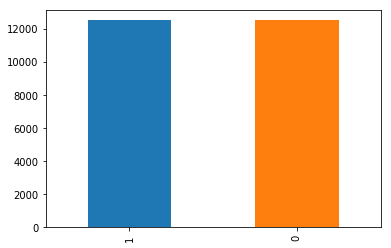

In [14]:
df["category"].value_counts().plot.bar()

Выберем случайное изображение и визуализируем его

In [15]:
import random

In [16]:
sample=random.choice(filenames)

In [17]:
sample

'dog.1421.jpg'

In [18]:
ls

 cats_vs_dogs_data/  'dogs vs cats.ipynb'   sampleSubmission.csv


In [19]:
image=load_img("cats_vs_dogs_data/train/" + sample)


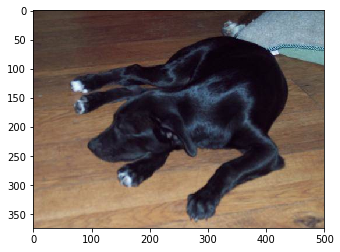

In [20]:
plt.imshow(image)

# Конструирование сети

In [21]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential

In [22]:
model= Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [24]:
from keras import optimizers

In [25]:
model.compile(loss="binary_crossentropy", optimizer = optimizers.RMSprop(lr=1e-4), metrics=["acc"]) 
# binary_cross_entropy - т.к. сеть на выходе выдает лишь один класс (кошка или собака)

# Callbacks

## EarlyStopping

In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [27]:
earlystop=EarlyStopping(patience=10)


Во избежание перебора мы остановим обучение после 10 эпох, и значение val_loss не уменьшится

## Снижение скорости обучения

Мы снизим скорость обучения, когда точность не увеличится за 2 шага

In [28]:
learning_rate_reduction= ReduceLROnPlateau(monitor="val_acc", patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [29]:
callbacks = [earlystop, learning_rate_reduction]

## Предварительная обработка данных

Как вы уже знаете, перед передачей в сеть данные должны быть преобразованы
в тензоры с вещественными числами. В настоящее время данные хранятся в виде
файлов JPEG, поэтому их нужно подготовить для передачи в сеть, выполнив сле-
дующие шаги:
1. Прочитать файлы с изображениями.
2. Декодировать содержимое из формата JPEG в таблицы пикселов RGB.
3. Преобразовать их в тензоры с вещественными числами.
4. Масштабировать значения пикселов из диапазона [0, 255] в диапазон [0, 1]
(как вы уже знаете, нейронным сетям предпочтительнее передавать небольшие
значения).


Этот порядок действий может показаться немного сложным, но, к счастью, в Keras
имеются утилиты, способные выполнить его автоматически. Во фреймворке Keras
имеется модуль keras.preprocessing.image с инструментами для обработки изо-
бражений. В частности, в нем вы найдете класс ImageDataGenerator , который по-
зволит быстро настроить генераторы Python для автоматического преобразования
файлов с изображениями в пакеты готовых тензоров. В листинге 5.7 показано, как
им воспользоваться

Зададим параметры дял будущих аугментаций (трансформаций) изображений

In [30]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Кодирование данных

In [31]:
df["category"] = df["category"].map({0: "cat", 1: "dog"})

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
train_df, validate_df = train_test_split(df, test_size= 0.2, random_state=42)

Сбрасываем индексы после случайного разбиения данных, чтобы они были по-порядку

In [34]:
train_df = train_df.reset_index(drop=True) 
validate_df=validate_df.reset_index(drop=True)

In [35]:
train_df.head()

,filename,category
0,dog.2350.jpg,dog
1,dog.7869.jpg,dog
2,cat.8575.jpg,cat
3,cat.3995.jpg,cat
4,dog.8307.jpg,dog


In [36]:
train_df["category"].value_counts()

dog    10046
cat     9954
Name: category, dtype: int64

In [37]:
validate_df["category"].value_counts()

cat    2546
dog    2454
Name: category, dtype: int64

In [38]:
train_df.shape

(20000, 2)

In [39]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

## Training and Validation Generator and Data Augmentation

In [40]:
from keras.preprocessing.image import ImageDataGenerator

Масштабирование значений

In [41]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, 
                                  shear_range= 0.1, zoom_range= 0.2, 
                                   horizontal_flip = True, width_shift_range=0.1, 
                                   height_shift_range=0.1)

valid_datagen= ImageDataGenerator(rescale=1./255) 
# для валидации не делаем аугментацию

In [42]:
pwd

'/home/dmitriy/DESKTOP/Python_NEW/Computer_vision'

In [43]:
train_generator = train_datagen.flow_from_dataframe(train_df, 
    directory="cats_vs_dogs_data/train/", x_col='filename',
    y_col='category', target_size=IMAGE_SIZE, batch_size=batch_size)

Found 20000 images belonging to 2 classes.


In [44]:
validation_generator=valid_datagen.flow_from_dataframe(
validate_df, "cats_vs_dogs_data/train/", x_col="filename", 
    y_col="category", target_size=IMAGE_SIZE, batch_size=batch_size)

Found 5000 images belonging to 2 classes.


In [45]:
example_df=train_df.sample(n=1).reset_index(drop=True)
example_generator=train_datagen.flow_from_dataframe(
example_df, "cats_vs_dogs_data/train/", x_col="filename", y_col="category",
target_size=IMAGE_SIZE, class_mode="categorical")

Found 1 images belonging to 1 classes.


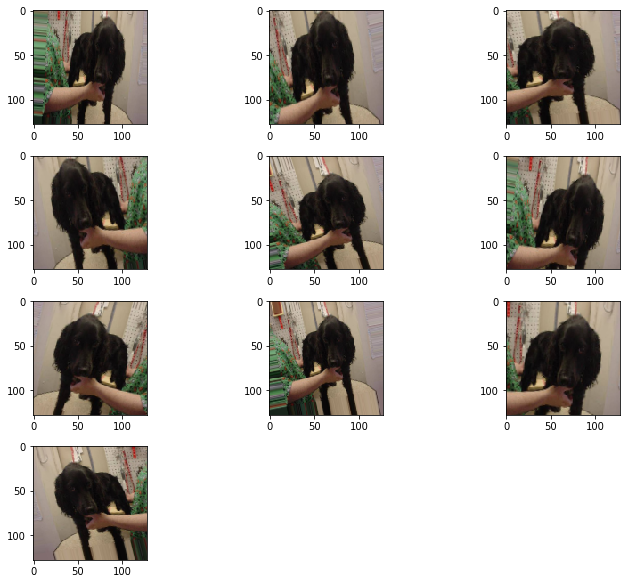

In [46]:
plt.figure(figsize=(10,10))
for i in range(0,10):
    plt.subplot(5,3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model 9 (адаптация модели)

In [64]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_41 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 30, 30, 64)        0         
__________

In [65]:
epochs=3
history = model.fit_generator(train_generator, epochs=epochs, 
                              validation_data=validation_generator,
                             validation_steps=total_validate//batch_size,
                             steps_per_epoch=100,
                             callbacks=callbacks)

Epoch 1/3
100/100 [==============================] - 168s 2s/step - loss: 1.3176 - acc: 0.5473 - val_loss: 2.2382 - val_acc: 0.4941
Epoch 2/3
100/100 [==============================] - 215s 2s/step - loss: 1.0637 - acc: 0.5380 - val_loss: 1.3371 - val_acc: 0.4177
Epoch 3/3
100/100 [==============================] - 410s 4s/step - loss: 0.9520 - acc: 0.5353 - val_loss: 1.2815 - val_acc: 0.4287

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


In [66]:
test_filenames=os.listdir("cats_vs_dogs_data/test1/")
test_df=pd.DataFrame({"filename": test_filenames})

In [75]:
nb_samples = test_df.shape[0]

In [67]:
test_df.shape

(12500, 1)

# Create Testing Generator

In [71]:
1./255

0.00392156862745098

In [72]:
test_gen=(ImageDataGenerator(rescale=1./255))

In [73]:
test_generator=test_gen.flow_from_dataframe(test_df, "cats_vs_dogs_data/test1/",
                                           x_col="filename", y_col=None, 
                                           class_mode=None, target_size=IMAGE_SIZE,
                                           batch_size=batch_size, shuffle=False)

Found 12500 images.


In [74]:
test_generator

In [78]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [82]:
predict

array([[0.30418384, 0.69581616],
       [0.8970502 , 0.10294975],
       [0.28638402, 0.713616  ],
       ...,
       [0.21041746, 0.7895825 ],
       [0.91160583, 0.08839413],
       [0.94398636, 0.05601368]], dtype=float32)

Для категральной классификации прогноз будет приходить с вероятностью каждой категории. Таким образом, мы выберем категорию с наибольшей вероятностью и средним максимальным значением.

In [79]:
test_df["category"] = np.argmax(predict, axis=1)

In [80]:
test_df.head()

,filename,category
0,6262.jpg,1
1,8288.jpg,0
2,11304.jpg,1
3,11082.jpg,0
4,2975.jpg,0


In [83]:


label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [85]:
test_df.head()

,filename,category
0,6262.jpg,cat
1,8288.jpg,dog
2,11304.jpg,cat
3,11082.jpg,dog
4,2975.jpg,dog


In [86]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [87]:
test_df.head()

,filename,category
0,6262.jpg,0
1,8288.jpg,1
2,11304.jpg,0
3,11082.jpg,1
4,2975.jpg,1


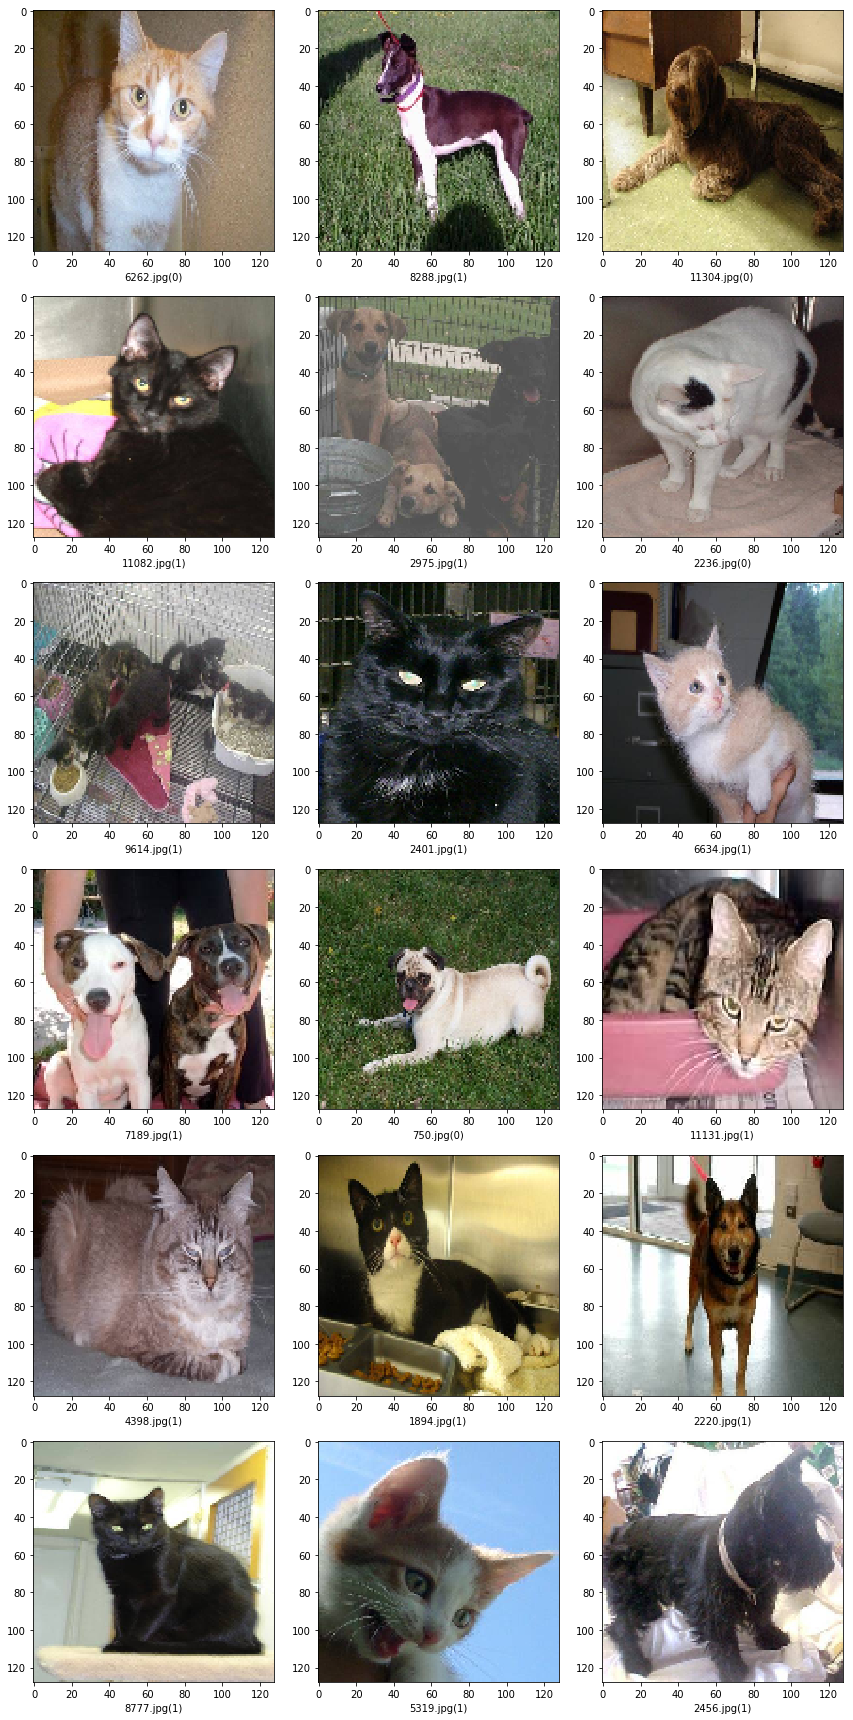

In [89]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("cats_vs_dogs_data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [90]:
submission_df=test_df.copy()

In [91]:
submission_df["id"] = submission_df["filename"].str.split(".").str[0]
submission_df["label"] =submission_df["category"]
submission_df.drop(["filename", "category"], axis=1, inplace=True)
submission_df.to_csv("submission.csv", index=False)

# TRANSFER LEARNING

Загрузим VGG16, обученную на ImageNet

Здесь конструктору передаются три аргумента:

- Аргумент weights определяет источник весов для инициализации модели.

- Аргумент include_top определяет необходимость подключения к сети полносвязного классификатора. По умолчанию этот полносвязный классификатор соответствует 1000 классов из ImageNet. Так как мы намереваемся использовать свой полносвязный классификатор (только с двумя классами: cat и dog ), мы не будем подключать его.

- Аргумент input_shape определяет форму тензоров с изображениями, которые
будут подаваться на вход сети. Это необязательный аргумент: если опустить его,
сеть сможет обрабатывать изображения любого размера.

In [92]:
from keras.applications import VGG16

In [94]:
conv_base=VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 99s 2us/step


In [96]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [97]:
img_path="cats_vs_dogs_data/train/cat.1.jpg"

In [105]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [122]:
img = image.load_img(img_path, target_size=(150, 150,3))

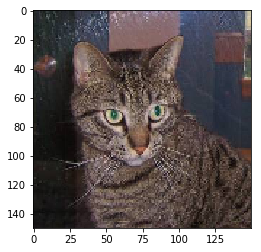

In [123]:
plt.imshow(img)

Массив Numpy с числами типа float32,
имеющий форму (224, 224, 3)

In [131]:
x=image.img_to_array(img)

Добавление размерности для преобразования
массива в пакет с формой (1, 224, 224, 3)

In [134]:
x = np.expand_dims(x, axis = 0)

In [135]:
x.shape

(1, 150, 150, 3)

In [138]:
x = preprocess_input(x)

Предварительная обработка пакета
(нормализация каналов цвета)

In [139]:
x

array([[[[ -63.939003,  -72.779   ,  -84.68    ],
         [ -59.939003,  -71.779   ,  -82.68    ],
         [ -55.939003,  -71.779   ,  -82.68    ],
         ...,
         [  59.060997,   67.221   ,   61.32    ],
         [  69.061   ,   87.221   ,   83.32    ],
         [  59.060997,   81.221   ,   77.32    ]],

        [[ -62.939003,  -71.779   ,  -83.68    ],
         [ -60.939003,  -72.779   ,  -83.68    ],
         [ -56.939003,  -72.779   ,  -83.68    ],
         ...,
         [  60.060997,   67.221   ,   61.32    ],
         [  62.060997,   78.221   ,   75.32    ],
         [  58.060997,   77.221   ,   75.32    ]],

        [[ -65.939   ,  -74.779   ,  -86.68    ],
         [ -66.939   ,  -78.779   ,  -89.68    ],
         [ -63.939003,  -79.779   ,  -90.68    ],
         ...,
         [  56.060997,   60.221   ,   56.32    ],
         [  59.060997,   72.221   ,   71.32    ],
         [  67.061   ,   83.221   ,   83.32    ]],

        ...,

        [[ -80.939   ,  -94.779   ,  -

In [140]:
preds=conv_base.predict(x)

In [130]:
print('Predicted:', decode_predictions(preds, top=3)[0])

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 4, 4, 512)

In [142]:
np.argmax(preds[0])

5406